In [8]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
import torchvision

from torchvision import datasets
from torchvision import transforms
from torchvision.utils import make_grid

from tqdm import tqdm
#from torchinfo import summary

import numpy as np
import matplotlib.pyplot as plt


In [9]:
print('GPU name:', torch.cuda.get_device_name(), '\n')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

GPU name: NVIDIA A100-PCIE-40GB 



# Load MNIST dataset


In [10]:
transform = transforms.Compose([transforms.Resize((32, 32)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5,), std=(0.5,))])

training_dataset = datasets.MNIST(root='./data_src', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data_src', train=False, download=True, transform=transform)

# Define dataloaders


In [11]:

training_dataloader = DataLoader(training_dataset, batch_size=32, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=True)

# Define Linear_Variance_Scheduler


In [12]:
import math

class Cosine_Variance_Scheduler:
    def __init__(self, time_steps, s=0.008, device='cuda'):
        self.time_steps = time_steps
        self.s = s
        self.device = device

        steps = torch.arange(self.time_steps + 1, dtype=torch.float64)  # T+1 steps for cosine schedule
        t = steps / self.time_steps

        # Compute alpha_bar using cosine schedule
        f = lambda t: torch.cos((t + self.s) / (1 + self.s) * math.pi / 2) ** 2
        alphas_cumprod = f(t) / f(torch.tensor(0.0, dtype=torch.float64))

        # alphas_cumprod[0] corresponds to time step -1, so shift by 1
        self.alpha_bar = alphas_cumprod[1:].to(self.device).float()
        # Now compute alphas and betas
        self.alphas = self.alpha_bar / torch.cat([torch.tensor([1.0], device=self.device), self.alpha_bar[:-1]])
        self.betas = 1 - self.alphas

        # Precompute square roots for efficiency
        self.sqrt_alpha_bar = torch.sqrt(self.alpha_bar)
        self.sqrt_one_minus_alpha_bar = torch.sqrt(1 - self.alpha_bar)
    def diffusion_process(self, x, noise, t):
        t = torch.clamp(t, max=self.time_steps - 1)  # Ensure t is within bounds
        sqrt_alpha_bar = self.sqrt_alpha_bar[t][:, None, None, None]
        sqrt_one_minus_alpha_bar = self.sqrt_one_minus_alpha_bar[t][:, None, None, None]
        return sqrt_alpha_bar * x + sqrt_one_minus_alpha_bar * noise
    
    # Reverse process
    def ddpm_sampling(self, model, num_samples, channels, img_size):
        model.eval()
        with torch.inference_mode():
            x = torch.randn((num_samples, channels, img_size, img_size)).to(self.device)
            collect = []
            for i in tqdm(reversed(range(self.time_steps))):
                t = (torch.ones(num_samples) * i).long().to(self.device)
                pred_noise = model(x, t)
                alphas = self.alphas[t][:, None, None, None]
                alpha_bar = self.alpha_bar[t][:, None, None, None]
                betas = self.betas[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alphas) * (x - ((1 - alphas) / (torch.sqrt(1 - alpha_bar))) * pred_noise) +\
                    torch.sqrt(betas) * noise
                if (i+1) % 100 == 0 or i==0:
                    collect.append(x)
        return x, collect

In [13]:
t_step = torch.linspace(start=0, end=1000-1, steps=11).long()
get_img = training_dataset[0][0]

get_img_stack = torch.stack([get_img]*11)
get_noise_stack = torch.randn_like(get_img_stack)

noisy_img_stack = Cosine_Variance_Scheduler(time_steps=1000, device='cpu').diffusion_process(get_img_stack, get_noise_stack, t_step)


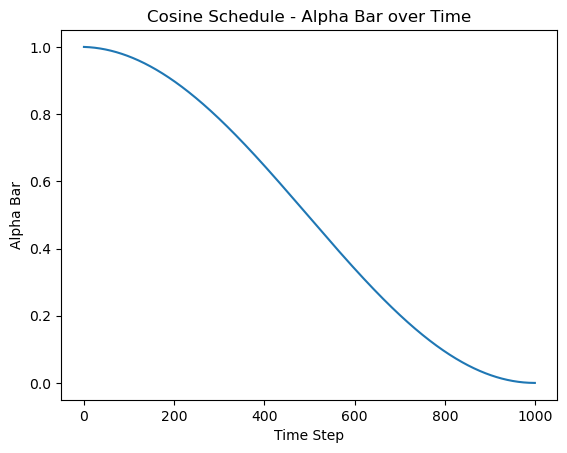

In [14]:
import matplotlib.pyplot as plt

# Initialize the scheduler
scheduler = Cosine_Variance_Scheduler(time_steps=1000, device='cpu')

# Plot alpha_bar
plt.plot(scheduler.alpha_bar.cpu())
plt.title('Cosine Schedule - Alpha Bar over Time')
plt.xlabel('Time Step')
plt.ylabel('Alpha Bar')
plt.show()


# Forward process output


In [26]:
t_step = torch.linspace(start=0, end=1000, steps=11).long()
get_img = training_dataset[0][0]

get_img_stack = torch.stack([get_img]*11)
get_noise_stack = torch.randn_like(get_img_stack)

In [16]:
noisy_img_stack = Cosine_Variance_Scheduler(time_steps=1000, device='cpu').diffusion_process(get_img_stack, get_noise_stack, t_step)


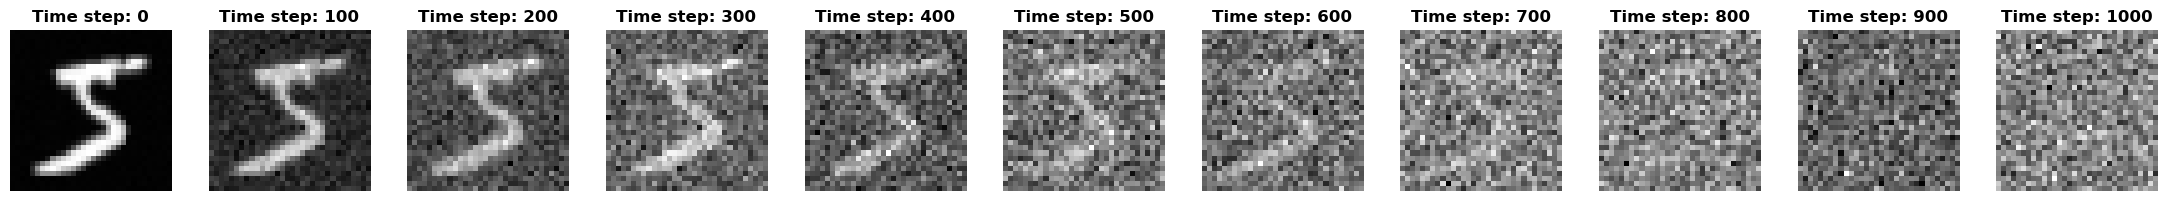

In [27]:
# Prepare the figure
fig, axes = plt.subplots(1, len(t_step), figsize=(22, 2))

# Loop through each time step and plot the corresponding image
for idx, ax in enumerate(axes):
    img = noisy_img_stack[idx].permute(1, 2, 0).squeeze().cpu().numpy()
    ax.imshow(img, cmap='gray')
    ax.set_title(f'Time step: {t_step[idx].item()}', fontweight='bold')
    ax.axis('off')

plt.tight_layout()
plt.show()

### Play with forward parameters

#### U-net Architecture:
- Resblock
- SelfAttentionBlock
- Downblock
- Upblock

# Create ResBlock

In [17]:
class ResBlock(nn.Module):
    def __init__(self, inp_ch, out_ch, mid_ch=None, residual=False):
        super(ResBlock, self).__init__()
        
        self.residual = residual
        if not mid_ch:
            mid_ch = out_ch
        self.resnet_conv = nn.Sequential()
        self.resnet_conv.add_module('conv1', nn.Conv2d(in_channels=inp_ch, out_channels=mid_ch, kernel_size=3, stride=1,
                                                       padding=1))
        self.resnet_conv.add_module('gnor1', nn.GroupNorm(num_groups=8, num_channels=mid_ch))
        self.resnet_conv.add_module('silu1', nn.SiLU())
        self.resnet_conv.add_module('conv2', nn.Conv2d(in_channels=mid_ch, out_channels=out_ch, kernel_size=3, stride=1,
                                                       padding=1))
        self.resnet_conv.add_module('gnor2', nn.GroupNorm(num_groups=8, num_channels=out_ch))
        
    def forward(self, x):
        if self.residual:
            return x + self.resnet_conv(x)
        else:
            return self.resnet_conv(x)

# Create SelfAttentionBlock

In [18]:
class SelfAttentionBlock(nn.Module):
    def __init__(self, channels):
        super(SelfAttentionBlock, self).__init__()
        
        self.attn_norm = nn.GroupNorm(num_groups=8, num_channels=channels)
        self.mha = nn.MultiheadAttention(embed_dim=channels, num_heads=4, batch_first=True)
        
    def forward(self, x):
        b, c, h, w = x.shape
        inp_attn = x.reshape(b, c, h*w)
        inp_attn = self.attn_norm(inp_attn)
        inp_attn = inp_attn.transpose(1, 2)
        out_attn, _ = self.mha(inp_attn, inp_attn, inp_attn)
        out_attn = out_attn.transpose(1, 2).reshape(b, c, h, w)
        return x + out_attn

# Create DownBlock

In [19]:
class DownBlock(nn.Module):
    def __init__(self, inp_ch, out_ch, t_emb_dim=256):
        super(DownBlock, self).__init__()
        
        self.down = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            ResBlock(inp_ch=inp_ch, out_ch=inp_ch, residual=True),
            ResBlock(inp_ch=inp_ch, out_ch=out_ch)
        )
        
        self.t_emb_layers = nn.Sequential()
        self.t_emb_layers.add_module('silu1', nn.SiLU())
        self.t_emb_layers.add_module('linr1', nn.Linear(in_features=t_emb_dim, out_features=out_ch))
        
    def forward(self, x, t):
        x = self.down(x)
        t_emb = self.t_emb_layers(t)[:, :, None, None].repeat(1, 1, x.shape[2], x.shape[3])
        return x + t_emb

# Create UpBlock

In [20]:
class UpBlock(nn.Module):
    def __init__(self, inp_ch, out_ch, t_emb_dim=256):
        super(UpBlock, self).__init__()
        
        self.upsamp = nn.UpsamplingBilinear2d(scale_factor=2)
        self.up = nn.Sequential(
            ResBlock(inp_ch=inp_ch, out_ch=inp_ch, residual=True),
            ResBlock(inp_ch=inp_ch, out_ch=out_ch, mid_ch=inp_ch//2)
        )
        
        self.t_emb_layers = nn.Sequential()
        self.t_emb_layers.add_module('silu1', nn.SiLU())
        self.t_emb_layers.add_module('linr1', nn.Linear(in_features=t_emb_dim, out_features=out_ch))
        
    def forward(self, x, skip, t):
        x = self.upsamp(x)
        x = torch.cat([skip, x], dim=1)
        x = self.up(x)
        t_emb = self.t_emb_layers(t)[:, :, None, None].repeat(1, 1, x.shape[2], x.shape[3])
        return x + t_emb

# Create UNet

In [21]:
class UNet(nn.Module):
    def __init__(self, t_emb_dim, device='cuda'):
        super(UNet, self).__init__()
        
        self.device = device
        self.t_emb_dim = t_emb_dim
        
        self.inp = ResBlock(inp_ch=1, out_ch=64)
        self.down1 = DownBlock(inp_ch=64, out_ch=128)
        self.sa1 = SelfAttentionBlock(channels=128)
        self.down2 = DownBlock(inp_ch=128, out_ch=256)
        self.sa2 = SelfAttentionBlock(channels=256)
        self.down3 = DownBlock(inp_ch=256, out_ch=256)
        self.sa3 = SelfAttentionBlock(channels=256)
        
        self.lat1 = ResBlock(inp_ch=256, out_ch=512)
        self.lat2 = ResBlock(inp_ch=512, out_ch=512)
        self.lat3 = ResBlock(inp_ch=512, out_ch=256)
        
        self.up1 = UpBlock(inp_ch=512, out_ch=128)
        self.sa4 = SelfAttentionBlock(channels=128)
        self.up2 = UpBlock(inp_ch=256, out_ch=64)
        self.sa5 = SelfAttentionBlock(channels=64)
        self.up3 = UpBlock(inp_ch=128, out_ch=64)
        self.sa6 = SelfAttentionBlock(channels=64)
        
        self.out = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)
        
    def position_embeddings(self, t, channels):
        i = 1 / (10000 ** (torch.arange(start=0, end=channels, step=2, device=self.device) / channels))
        pos_emb_sin = torch.sin(t.repeat(1, channels//2) * i)
        pos_emb_cos = torch.cos(t.repeat(1, channels//2) * i)
        pos_emb = torch.cat([pos_emb_sin, pos_emb_cos], dim=-1)
        return pos_emb
    
    def forward(self, x, t):
        t = t.unsqueeze(1).float()
        t = self.position_embeddings(t, self.t_emb_dim)
        
        x1 = self.inp(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)
        
        x4 = self.lat1(x4)
        x4 = self.lat2(x4)
        x4 = self.lat3(x4)
        
        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.out(x)
        return output

In [22]:
from torchinfo import summary

summary(UNet(t_emb_dim=256), input_size=[(64, 1, 32, 32), (64,)])


Layer (type:depth-idx)                        Output Shape              Param #
UNet                                          [64, 1, 32, 32]           --
├─ResBlock: 1-1                               [64, 64, 32, 32]          --
│    └─Sequential: 2-1                        [64, 64, 32, 32]          --
│    │    └─Conv2d: 3-1                       [64, 64, 32, 32]          640
│    │    └─GroupNorm: 3-2                    [64, 64, 32, 32]          128
│    │    └─SiLU: 3-3                         [64, 64, 32, 32]          --
│    │    └─Conv2d: 3-4                       [64, 64, 32, 32]          36,928
│    │    └─GroupNorm: 3-5                    [64, 64, 32, 32]          128
├─DownBlock: 1-2                              [64, 128, 16, 16]         --
│    └─Sequential: 2-2                        [64, 128, 16, 16]         --
│    │    └─MaxPool2d: 3-6                    [64, 64, 16, 16]          --
│    │    └─ResBlock: 3-7                     [64, 64, 16, 16]          74,112
│    │   

# SET-UP

In [23]:
ddpm = Cosine_Variance_Scheduler(time_steps=1000)
model = UNet(t_emb_dim=256).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


# TRAINING

In [24]:
torch.manual_seed(1111)
torch.cuda.manual_seed(1111)
torch.cuda.manual_seed_all(1111)
np.random.seed(1111)

n_epochs = 2
training_loss, test_loss,generated_cpu, fid_scores = [], [],  [], []

for epoch in range(n_epochs):
    training_losses, test_losses = [], []
    
    for data, _ in tqdm(training_dataloader):
        model.train()
        data = data.to(device)
        t = torch.randint(low=0, high=1000, size=(data.shape[0],)).to(device)
        noise = torch.randn_like(data)
        xt = ddpm.diffusion_process(x=data, noise=noise, t=t)
        pred_noise = model(xt, t)
        trng_batch_loss = criterion(noise, pred_noise)
        optimizer.zero_grad()
        trng_batch_loss.backward()
        optimizer.step()
        training_losses.append(trng_batch_loss.item())
    training_per_epoch_loss = np.array(training_losses).mean()
    
    with torch.inference_mode():
        for data, _ in tqdm(test_dataloader):
            model.eval()
            data = data.to(device)
            t = torch.randint(low=0, high=1000, size=(data.shape[0],)).to(device)
            noise = torch.randn_like(data)
            xt = ddpm.diffusion_process(x=data, noise=noise, t=t)
            pred_noise = model(xt, t)
            tst_batch_loss = criterion(noise, pred_noise)
            test_losses.append(tst_batch_loss.item())
        test_per_epoch_loss = np.array(test_losses).mean()

    training_loss.append(training_per_epoch_loss)
    test_loss.append(test_per_epoch_loss)
    
    print(f'Epoch: {epoch+1}/{n_epochs}\t| Training loss: {training_per_epoch_loss:.4f} |   ', end='')
    print(f'Test loss: {test_per_epoch_loss:.4f}')
    


100%|██████████| 312/312 [00:06<00:00, 49.10it/s]


Epoch: 1/2	| Training loss: 0.0690 |   Test loss: 0.0447


100%|██████████| 312/312 [00:06<00:00, 46.07it/s]

Epoch: 2/2	| Training loss: 0.0412 |   Test loss: 0.0373


# Plot losses

# Reverse process

In [28]:
_, collect = ddpm.ddpm_sampling(model=model, num_samples=1, channels=1, img_size=32)


1000it [00:07, 140.70it/s]


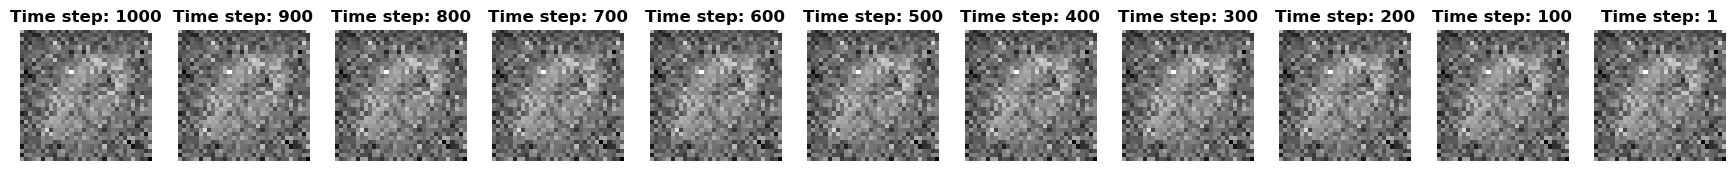

In [29]:
step = [1000, 900, 800, 700, 600, 500, 400, 300, 200, 100, 1]
fig, axis = plt.subplots(nrows=1, ncols=11, figsize=(22, 2))

j = 0
for ax, _ in zip(axis.ravel(), range(11)):
    ax.imshow(collect[j][0].detach().cpu().permute(1, 2, 0), cmap='gray')
    ax.set_title(f'Time step: {step[j]}', fontweight='bold')
    ax.axis(False)
    j += 1

# Random sampling from noise

In [30]:
sampled_imgs, _ = ddpm.ddpm_sampling(model=model, num_samples=64, channels=1, img_size=32)



1000it [00:23, 43.48it/s]


(-0.5, 545.5, 137.5, -0.5)

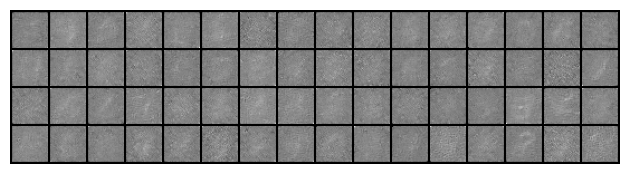

In [31]:
grid = make_grid(sampled_imgs.detach().cpu(), nrow=16, normalize=True)
plt.figure(figsize=(12, 2))
plt.imshow(grid.permute(1, 2, 0), cmap='gray')
plt.axis(False)

**TODO**
## EVALUATION

###  THIRD METHOD

It measures how similar the generated images are to real images by comparing their feature distributions extracted from a pre-trained neural network (InceptionV3). How ? 

1. Collect Real Images
2. Preprocess Images: Both real and generated images are resized to 299x299 pixels because InceptionV3 expects this input size. Convert to RGB,Normalize.
3. Extract Features Using InceptionV3
4. Compute Statistics of Activations for the real images and for the generated images: mean and covariance
5. Calculate the Fréchet Distance (FID Score)

##### Why This Method Works:
**Feature Comparison**: Instead of comparing images pixel by pixel, which doesn't capture high-level similarities, we compare the statistical properties of features extracted by a deep network trained on a large dataset.
**Capturing Perceptual Differences**: The InceptionV3 model's features capture important aspects of images that are relevant to human perception, making FID a good proxy for visual quality.

In [ ]:
N = 10000
test_dataset_no_transform = datasets.MNIST(
    root='./data_src', train=False, download=True, transform=None
)

indices = list(range(N))

In [62]:
def preprocess_image(image):
    image = image.clamp(0, 1)  # Ensure pixel values are in [0, 1]
    image = transforms.ToPILImage()(image)
    image = transforms.Resize((299, 299))(image)
    image = transforms.ToTensor()(image)
    image = image.repeat(3, 1, 1)  # Convert grayscale to RGB by repeating channels
    image = transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )(image)
    return image

In [63]:
class GeneratedImagesDataset(torch.utils.data.Dataset):
    def __init__(self, images):
        self.images = images  # Tensor of shape (N, 1, 32, 32)
        
    def __len__(self):
        return self.images.shape[0]
    
    def __getitem__(self, idx):
        img = self.images[idx]
        img = (img + 1) / 2  # Scale from [-1, 1] to [0, 1]
        img = preprocess_image(img)
        return img

In [64]:
generated_dataset = GeneratedImagesDataset(sampled_imgs)
generated_dataloader = DataLoader(generated_dataset, batch_size=64, shuffle=False)

In [65]:
class RealImagesDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset, indices):
        self.base_dataset = base_dataset  # MNIST dataset without transforms
        self.indices = indices  # Indices of images to include
        
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        base_idx = self.indices[idx]
        img_pil, _ = self.base_dataset[base_idx]
        img = transforms.ToTensor()(img_pil)  # Convert PIL image to tensor in [0, 1]
        img = preprocess_image(img)
        return img

In [66]:
real_dataset = RealImagesDataset(test_dataset_no_transform, indices)
real_dataloader = DataLoader(real_dataset, batch_size=64, shuffle=False)

In [67]:
import torchvision.models as models
from torchvision.models.inception import Inception_V3_Weights

model_inception = models.inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1)
model_inception.fc = nn.Identity()  # Remove the final classification layer
model_inception.to(device)
model_inception.eval()

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to C:\Users\Leuro/.cache\torch\hub\checkpoints\inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:03<00:00, 33.0MB/s] 


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [68]:
def get_activation(dataloader, model, device='cpu'):
    """
    Given a dataloader and a model, generate an N x 2048-dimensional
    activation map for N data points in the dataloader.
    """
    model.to(device)
    model.eval()
    
    # Store activations
    pred_arr = np.zeros((len(dataloader.dataset), 2048))
    
    batch_size = dataloader.batch_size
    
    with torch.no_grad():
        for i, batch in enumerate(tqdm(dataloader)):
            batch = batch.to(device)
            pred = model(batch).cpu().numpy()
            start_idx = i * batch_size
            end_idx = start_idx + batch.shape[0]
            pred_arr[start_idx:end_idx] = pred
            
    return pred_arr

In [69]:
def calculate_activation_statistics(dataloader, model, device='cpu'):
    """
    Get the mean vector and covariance matrix of the activation maps.
    """
    act = get_activation(dataloader, model, device)
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

In [70]:
from scipy import linalg

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """
    Given means and covariance matrices of real and generated data,
    calculates the Fréchet Distance (FID score) between them.
    """
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)
    
    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)
    
    diff = mu1 - mu2
    
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    
    # Handle singularities
    if not np.isfinite(covmean).all():
        print("Adding epsilon to diagonal of covariance matrices to avoid singularities.")
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))
    
    # Check for imaginary numbers
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    tr_covmean = np.trace(covmean)
    
    fid = diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean
    return fid

In [71]:
mu_gen, sigma_gen = calculate_activation_statistics(
    generated_dataloader, model_inception, device=device
)

100%|██████████| 1/1 [00:00<00:00,  1.71it/s]


In [72]:
mu_real, sigma_real = calculate_activation_statistics(
    real_dataloader, model_inception, device=device
)

100%|██████████| 157/157 [00:37<00:00,  4.23it/s]


In [73]:
fid_value = calculate_frechet_distance(mu_gen, sigma_gen, mu_real, sigma_real)
print(f'FID Score: {fid_value}')

FID Score: 69.73937417377834


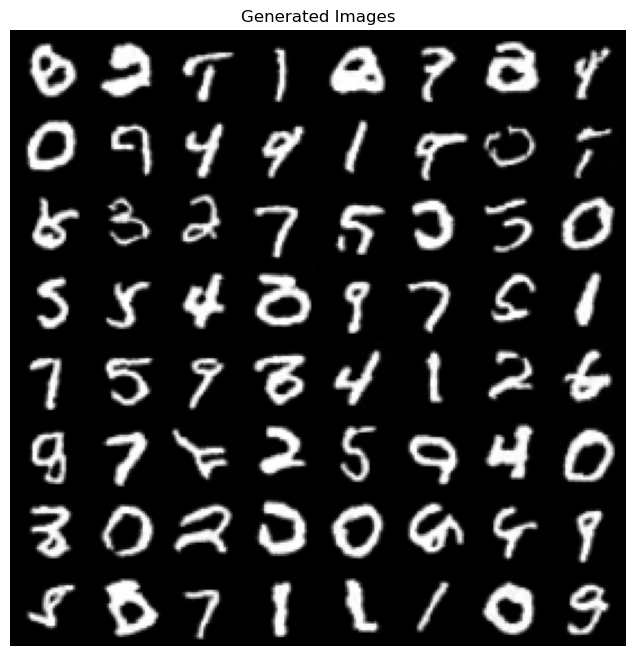

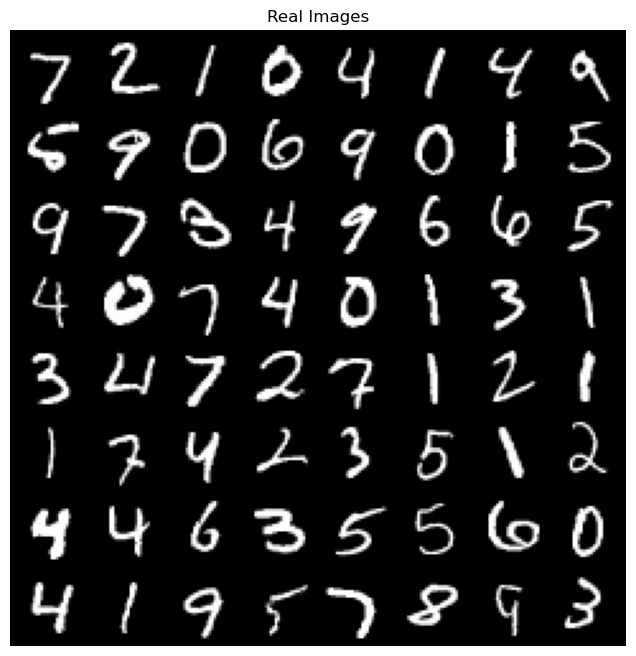

In [76]:
# Convert images to [0, 1] range for visualization
sampled_imgs_0_1 = (sampled_imgs + 1) / 2
grid = make_grid(sampled_imgs_0_1[:64], nrow=8)

plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.title('Generated Images')
plt.axis('off')
plt.show()

real_images = []
for idx in range(64):
    img_pil, _ = test_dataset_no_transform[indices[idx]]
    img_tensor = transforms.ToTensor()(img_pil)
    real_images.append(img_tensor)

real_images = torch.stack(real_images)
grid_real = make_grid(real_images, nrow=8)

plt.figure(figsize=(8, 8))
plt.imshow(grid_real.permute(1, 2, 0).cpu().numpy())
plt.title('Real Images')
plt.axis('off')
plt.show()